Simple Tag
https://www.pettingzoo.ml/mpe/simple_tag

> This is a predator-prey environment. Good agents (green) are faster and receive a negative reward for being hit by adversaries (red) (-10 for each collision). Adversaries are slower and are rewarded for hitting good agents (+10 for each collision). Obstacles (large black circles) block the way. By default, there is 1 good agent, 3 adversaries and 2 obstacles.

Test baseline agent algorithms (MLP, MLP+GRU) on PettingZoo simple_tag environment, with stationary good agents.

In [7]:
import os
import time
import enum
import math
import random
import collections
import statistics
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import imageio

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

class TimeDelta(object):
    def __init__(self, delta_time):
        """Convert time difference in seconds to days, hours, minutes, seconds.
        
        Parameters
        ==========
        delta_time : float
            Time difference in seconds.
        """
        self.fractional, seconds = math.modf(delta_time)
        seconds = int(seconds)
        minutes, self.seconds = divmod(seconds, 60)
        hours, self.minutes = divmod(minutes, 60)
        self.days, self.hours = divmod(hours, 24)
    
    def __repr__(self):
        return f"{self.days}-{self.hours:02}:{self.minutes:02}:{self.seconds + self.fractional:02}"

from pettingzoo.mpe import simple_tag_v2
from pettingzoo.utils import random_demo

# torch.autograd.set_detect_anomaly(True)

Arguments in instantiate environment.

- num_good: number of good agents
- num_adversaries: number of adversaries
- num_obstacles: number of obstacles
- max_cycles: number of frames (a step for each agent) until game terminates
- continuous_actions: Whether agent action spaces are discrete(default) or continuous

In [8]:
env = simple_tag_v2.env(
    num_good=1,
    num_adversaries=1,
    num_obstacles=0,
    max_cycles=30,
    continuous_actions=False
).unwrapped

### What are the environment parameters?

Adversaries (red) capture non-adversary (green). The map is a 2D grid and everything is initialized in the region [-1, +1]. There doesn't seem to be position clipping for out of bounds, but non-adversary agent are penalized for out of bounds.
Agent's observation is a ndarray vector of concatenated data in the following order:

1. current velocity (2,)
2. current position (2,)
3. relative position (2,) of each landmark
4. relative position (2,) of each other agent
5. velocity (2,) of each other non-adversary agent

When there are 3 adverseries and 3 non-adversaries, then advarsary observation space is 24 dimensional and non-advarsary observation space is 22 dimensional.

The environment is sequential. Agents move one at a time. Agents are either `adversary_*` for adversary or `agent_*` for non-adversary.

Actions:

- 0 is NOP
- 1 is go left
- 2 is go right
- 3 is go down
- 4 is go up

### How to train the agents?

When loss is increasing for Double DQN, then increase the interval for updating target network.
<https://stackoverflow.com/questions/56964657/cartpole-v0-loss-increasing-using-dqn>

In [19]:
env.reset()

def get_agent_counts():
    all_agents = 0
    adversaries = 0
    for agent in env.world.agents:
        all_agents += 1
        adversaries += 1 if agent.adversary else 0
    good_agents = all_agents - adversaries
    return (adversaries, good_agents)

def get_landmark_count():
    return len(env.world.landmarks)

def process_config(config):
    for k, v in config.common.items():
        config.adversary[k] = v
        config.agent[k] = v

n_adversaries, n_good_agents = get_agent_counts()
n_landmarks = get_landmark_count()
config = AttrDict(
    n_adversaries=n_adversaries,
    n_good_agents=n_good_agents,
    n_landmarks=n_landmarks,
    discount = 0.99,
    eps_start = 0.9,
    eps_end = 0.05,
    eps_decay = 0.9996,
    n_episodes=1000,
    batch_size=1,
    update_target_interval=32,
    # how frequently to compute running means of losses and rewards
    report_interval=32,
    # how frequently to visualize an episode in a window
    visualize_interval=32,
    # how frequently to evaluate agents, and save the results
    evaluation_interval=500,
    # how many episodes to run for each evaluation
    n_eval_episodes=100,
    # whether to visualize in a window when evaluating 
    visualize_on_evaluation=True,
    clip_grad_norm=5.0,
    lr=0.05,
    device_id="cuda" if torch.cuda.is_available() else "cpu",
    common=AttrDict(
        hidden_size=32,
        enable_rnn=True,
        n_rnn_layers=1,
        n_actions=env.action_space(env.agent_selection).n,
    ),
    adversary=AttrDict(
        n_agents=n_adversaries,
        observation_shape=env.observation_space("adversary_0").shape

    ),
    agent=AttrDict(
        n_agents=n_good_agents,
        observation_shape=env.observation_space("agent_0").shape
    )
)

config.exp_name = (f"advonly_nadversaries{config.n_adversaries}"
                   f"_ngoodagents{config.n_good_agents}"
                   f"_landmarks{config.n_landmarks}")
process_config(config)
config

{'n_adversaries': 1,
 'n_good_agents': 1,
 'n_landmarks': 0,
 'discount': 0.99,
 'eps_start': 0.9,
 'eps_end': 0.05,
 'eps_decay': 0.9996,
 'n_episodes': 1000,
 'batch_size': 1,
 'update_target_interval': 32,
 'report_interval': 32,
 'visualize_interval': 32,
 'evaluation_interval': 500,
 'n_eval_episodes': 100,
 'visualize_on_evaluation': True,
 'clip_grad_norm': 5.0,
 'lr': 0.05,
 'device_id': 'cuda',
 'common': {'hidden_size': 32,
  'enable_rnn': True,
  'n_rnn_layers': 1,
  'n_actions': 5},
 'adversary': {'n_agents': 1,
  'observation_shape': (8,),
  'hidden_size': 32,
  'enable_rnn': True,
  'n_rnn_layers': 1,
  'n_actions': 5},
 'agent': {'n_agents': 1,
  'observation_shape': (6,),
  'hidden_size': 32,
  'enable_rnn': True,
  'n_rnn_layers': 1,
  'n_actions': 5},
 'exp_name': 'advonly_nadversaries1_ngoodagents1_landmarks0'}

In [20]:
class Normalizer(object):
    def __init__(self, env):
        self.n_landmarks = len(env.world.landmarks)
        self.n_allagents = len(env.world.agents)
        self.n_good = sum(map(lambda a: not a.adversary, env.world.agents))
    
    @staticmethod
    def normalize_abs_pos(s):
        """Clip absolute position and scale to [-1, 1]
        s is a scalar or an ndarray of one dimension."""
        return np.clip(s, -1.5, 1.5) / 1.5

    @staticmethod
    def normalize_rel_pos(s):
        """Clip relative position and scale to [-1, 1]
        s is a scalar or an ndarray of one dimension."""
        return np.clip(s, -3, 3) / 3

    def __call__(self, obs):
        # normalize and clip positions
        norm_obs = obs.copy()
        # normalize velocity of current entity
        norm_obs[:2] = norm_obs[:2] / 1.3
        # clip/scale abs. position of current entity
        norm_obs[2:4] = self.normalize_abs_pos(norm_obs[2:4])
        # clip/scale rel. position of other entities
        n_range = self.n_landmarks + self.n_allagents - 1
        for i in range(n_range):
            norm_obs[4 + (2*i):4 + (2*(i + 1))] = self.normalize_rel_pos(
                norm_obs[4 + (2*i):4 + (2*(i + 1))]
            )
        # normalize velocity of other entities
        norm_obs[4 + (2*n_range):] = norm_obs[4 + (2*n_range):] / 1.3
        return norm_obs
    
class RewardsShaper(object):
    # rdist - distance between adversary-good agent to start computing rewards.
    rdist = 1
    # collision_dist - distance between adversary-good agent to count collision.
    #    Based on PettingZoo numbers. 
    collision_dist = 0.075 + 0.05
    
    def __init__(self, env):
        self.n_landmarks = len(env.world.landmarks)
        # self.n_allagents = len(env.world.agents)
        self.name_to_idx = {agent.name: i for i, agent in enumerate(env.world.agents)}
        self.idx_to_name = {i: agent.name for i, agent in enumerate(env.world.agents)}
        self.goodagent_indices = [
            i for i, agent in enumerate(env.world.agents) if agent.name.startswith("agent")
        ]
        self.adversary_indices = [
            i for i, agent in enumerate(env.world.agents) if agent.name.startswith("adversary")
        ]

    @staticmethod
    def bound(x):
        if x < 0.9:
            return 0
        if x < 1.0:
            return (x - 0.9) * 10
        return min(np.exp(2 * x - 2), 10)

    def __call__(self, agent_name, obs):
        """Compute reshaped rewards from observation for agent given agent name.
        Adversary: start gaining small rewards as it nears good agents.
        
        Good agent: starts gaining small penality as it nears bad agents.
        """
        _obs = obs[4 + (2*self.n_landmarks):]
        agent_idx = self.name_to_idx[agent_name]
        cum_r = 0.
        if agent_name.startswith("agent"):
            # penalty across all adversaries
            for adversary_idx in self.adversary_indices:
                # penalty from distance of adversary; penalty of collision
                other_idx = adversary_idx - 1 if agent_idx < adversary_idx else adversary_idx
                x, y = _obs[2*other_idx:(2*other_idx) + 2]
                d    = math.sqrt(x**2 + y**2)
                cum_r -= 1 - (1/self.rdist)*d
        
        elif agent_name.startswith("adversary"):
            # reward across all agents
            for goodagent_idx in self.goodagent_indices:
                # reward from distance to agent; reward of collision
                other_idx = goodagent_idx - 1 if agent_idx < goodagent_idx else goodagent_idx
                x, y = _obs[2*other_idx:(2*other_idx) + 2]
                d    = math.sqrt(x**2 + y**2)
                cum_r += 1 - (1/self.rdist)*d
        
        return cum_r

normalize = Normalizer(env) # norm_obs = normalize(obs)
shapereward = RewardsShaper(env) # reward = shapereward(agent_name, obs)
criterion = torch.nn.MSELoss()
# criterion = torch.nn.SmoothL1Loss()

In [21]:
class SimpleTagNet(torch.nn.Module):
    """NN Model for the agents. Both good agents and adversaries use this model."""
        
    def __init__(self, config, agent_type):
        super().__init__()
        self.device      = torch.device(config.device_id)
        self.observation_size = math.prod(config[agent_type].observation_shape)
        self.n_actions   = config[agent_type].n_actions
        self.hidden_size = config[agent_type].hidden_size
        self.n_rnn_layers = config[agent_type].n_rnn_layers
        self.enable_rnn = config[agent_type].enable_rnn
        
        if self.enable_rnn:
            self.mlp = torch.nn.Sequential(
                torch.nn.Linear(self.observation_size, self.hidden_size),
                torch.nn.ReLU(inplace=True),
            )
            self.rnn = torch.nn.GRU(
                input_size=self.hidden_size,
                hidden_size=self.hidden_size,
                num_layers=self.n_rnn_layers,
                batch_first=True
            )
            self.output_mlp = torch.nn.Linear(self.hidden_size, self.n_actions)
        else:
            self.output_mlp = torch.nn.Sequential(
                torch.nn.Linear(self.observation_size, self.hidden_size),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(self.hidden_size, self.hidden_size),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(self.hidden_size, self.n_actions)
            )
    
    def forward(self, observation, hidden=False):
        """Apply DQN to episode step.
        
        Parameters
        ==========
        observation : ndarray
            The observation vector obtained from the environment.
        
        Returns
        =======
        torch.Tensor
            Vector of Q-value associated with each action.
        """
        observation = normalize(observation)
        observation = torch.tensor(observation, dtype=torch.float, device=self.device)
        if self.enable_rnn:
            z = self.mlp(observation)
            z = z.unsqueeze(0).unsqueeze(0)
            z, hidden = self.rnn(z, hidden)
            z = z.squeeze(0).squeeze(0)
            Q = self.output_mlp(z)
            return Q, hidden
        else:
            Q = self.output_mlp(observation)
            return Q, None

def choose_action(config, agent_type, Q, epsilon=0.05, is_val=False):
    if not is_val and random.random() < epsilon:
        return random.randrange(config[agent_type].n_actions)
    else:
        return torch.argmax(Q).item()

In [22]:
def pad_amt(w,  macro_block_size=16):
    amt = w % macro_block_size
    if amt > 0:
        return macro_block_size - amt
    else:
        return 0
    amt =  macro_block_size - (w % macro_block_size)

def pad_image(img, macro_block_size=16):
    """Pad a image of shape (W, H, C)"""
    _pad_amt = lambda w: pad_amt(w)
    return np.pad(img, [(0, _pad_amt(img.shape[0])), (0, _pad_amt(img.shape[1])), (0, 0)])

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def pad_values_front(a, n):
    """Zero out beginning of last axis"""
    pad_width = [(0, 0) for _ in range(a.ndim - 1)] + [(n, 0)]
    return np.pad(a, pad_width, mode='constant', constant_values=0)

def plot_training_run(savedir, logger):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    axes = axes.ravel()

    axes[0].plot(logger.episodic_losses.adversary, label="adversary")
    axes[0].set_title("adversary loss")
    axes[0].legend()

    axes[1].plot(logger.episodic_rewards.adversary, label="adversary")
    axes[1].set_title("reward")
    axes[1].legend()

    _moving_average = lambda a, n=64: pad_values_front(moving_average(a, n=n), n=n)
    adversary_episodic_rewards = np.array(logger["episodic_rewards"]["adversary"])
    avg_adversary_episodic_rewards = _moving_average(adversary_episodic_rewards)
    axes[2].plot(avg_adversary_episodic_rewards, label="adversary mean")
    axes[2].set_title("reward")
    axes[2].legend()
    fig.savefig(savedir, "training_run.png")

In [23]:
def run_episode(
    config, adversary_net, epsilon=0.05,
    should_render=False, is_val=False, save_video=False, save_video_path=None
):
    """Run one episodes.
    
    inputs consist of observation, message (backprop), hidden (backprop) indexed by agent
    outputs consist of action, q-value of action (backprop), reward, done indexed by (step, agent)
    
    Returns
    =======
    AttrDict
        Contains episode metrics:
        - steps : number of steps. All agents take an action at each step.
        - reward : episodic rewards indexed by ('adversary', 'agent').
        - step_records : list of quantities produced indiced by step, ('adversary', 'agent'), agent index.
          Each step record has:
            + observation
            + Q
            + reward
            + done
        - loss : contains episodic losses indexed by ('adversary', 'agent'). To be updated by train_agents()
    """
    rendered_video = []
    episode = AttrDict(
        steps=0,
        reward=AttrDict(adversary=0, agent=0),
        step_records=[],
    )
    n_agents = config.adversary.n_agents + config.agent.n_agents
    step_record = None
    hidden = None
    env.reset()
    for agent_step_idx, agent_name in enumerate(env.agent_iter()):
        if agent_step_idx % n_agents == 0:
            episode.steps += 1
            step_record = AttrDict(adversary={}, agent={})
            episode.step_records.append(step_record)
            
        obs_curr, reward, done, _ = env.last()
        if not is_val:
            reward += shapereward(agent_name, obs_curr)
        if should_render:
            env.render()
            if agent_name == "adversary_0":
                # print("rew, shaped rew", round(_reward, 2), round(reward, 2))
                # print("obs, normed obs", np.round(obs_curr, 2), np.round(normalize(obs_curr), 2))
                # print("obs, normed obs", np.round(obs_curr[4:6], 2), np.round(normalize(obs_curr[4:6]), 2))
                # print("obs, rew", np.round(normalize(obs_curr[4:6]), 2), reward)
                pass
            time.sleep(0.05)
        
        if save_video:
            rendered_image = env.render(mode='rgb_array')
            rendered_video.append(pad_image(rendered_image))

        agent_type, agent_idx = agent_name.split("_")
        agent_idx = int(agent_idx)
        if done:
            step_record[agent_type][agent_idx] = AttrDict(
                observation=obs_curr,
                action=None,
                reward=reward,
                done=done,
            )
            env.step(None)
            continue
        if agent_type == "agent":
            env.step(0)
            step_record[agent_type][agent_idx] = AttrDict(
                observation=obs_curr,
                action=0,
                reward=reward,
                done=done,
            )
        else:
            # agent_type == "adversary"
            Q_curr, hidden = adversary_net(obs_curr, hidden)
            action = choose_action(config, agent_type, Q_curr, epsilon, is_val=is_val)
            env.step(action)
            step_record[agent_type][agent_idx] = AttrDict(
                observation=obs_curr,
                action=action,
                reward=reward,
                done=done,
            )
        episode.reward[agent_type] += reward
    
    if should_render:
        env.close()
    if save_video:
        imageio.mimwrite(save_video_path, rendered_video, fps=30)
    return episode

def train_agents(
    config, device, batch, adversary_net,
    adversary_target_net, adversary_optimizer
):
    """Compute loss of episode and update agent weights."""
    adversary_optimizer.zero_grad()
    discount = torch.tensor(config.discount, dtype=torch.float, device=device)
    adversary_losses = []
    
    for episode in batch:
        hidden = None
        target_hidden = None
        for step_idx in range(episode.steps):
            # Optimize adversary network
            for agent_idx in episode.step_records[step_idx].adversary.keys():
                curr_record = episode.step_records[step_idx].adversary[agent_idx]
                if curr_record.done:
                    # agent is done at this step
                    continue
                next_record = episode.step_records[step_idx + 1].adversary[agent_idx]
                r = torch.tensor(next_record.reward, dtype=torch.float, device=device)
                y = None
                if next_record.done:
                    # agent terminates at next step
                    y = r
                else:
                    with torch.no_grad():
                        next_o = next_record.observation
                        target_Q, target_hidden = adversary_target_net(next_o, target_hidden)
                        max_target_Q = torch.max(target_Q)
                        y = r + discount*max_target_Q
                curr_o = curr_record.observation
                u = curr_record.action
                Q, hidden = adversary_net(curr_o, hidden)
                Q_u = Q[u]
                adversary_losses.append(criterion(y, Q_u))

    show_norms = False
    adversary_loss = torch.mean(torch.stack(adversary_losses))
    adversary_loss.backward()

    if show_norms: # for debugging
        norms = [p.grad.detach().data.norm().item() for p in adversary_net.parameters()]
        print("norm of gradiants", *np.round(norms, 2))

    torch.nn.utils.clip_grad_norm_(adversary_net.parameters(), config.clip_grad_norm)
    adversary_optimizer.step()
    
    return AttrDict(
        adversary=[loss.item() for loss in adversary_losses]
    )

def save_agent(savepath, net):
    torch.save(net.state_dict(), savepath)

def evaluate_agents(config, savedir, episode_idx, adversary_net):
    videodir = os.path.join(savedir, "videos")
    save_agent(os.path.join(savedir, f"adversary-net-{episode_idx}.pth"), adversary_net)
    adversary_net.eval()
    episodic_rewards=AttrDict(adversary=[])
    with torch.no_grad():
        for e in range(config.n_eval_episodes):
            save_video = e % 10 == 0
            validation_save_path = None
            should_render = False
            if save_video:
                validation_save_dir = os.path.join(videodir, f"epoch{episode_idx}")
                os.makedirs(validation_save_dir, exist_ok=True)
                validation_save_path = os.path.join(validation_save_dir, f"eval{e}.mp4")
                should_render = config.visualize_on_evaluation
            episode = run_episode(
                config, adversary_net,
                should_render=should_render, save_video=save_video,
                save_video_path=validation_save_path, is_val=True
            )
            episodic_rewards.adversary.append(episode.reward.adversary)
    avg_adversary_rewards = statistics.fmean(episodic_rewards.adversary)
    print(f"Average evaluation reward at episode {episode_idx} is: ")
    print(f"    adversary {avg_adversary_rewards:.2f}")
    adversary_net.train()
    return episodic_rewards

def train(config):
    """
    - Use parameter sharing between agents of the same class.
    - Good agents use one RL model, adversaries use another RL model.
      Train the agents side by side.
    - Separate, disjoint communication channels for two classes of agents,
      maintained by a container to store the messages.
    """
    datestamp = time.strftime('%d_%b_%Y_%H_%M_%S', time.localtime())
    savedir = os.path.join("models", config.exp_name, datestamp)
    os.makedirs(savedir, exist_ok=True)
    with open(os.path.join(savedir, "config.json"), "w") as f:
         json.dump(config, f)
        
    print("Training the agents...")
    t0 = time.time()
    device = torch.device(config.device_id)
    adversary_net = SimpleTagNet(config, "adversary").to(device)
    adversary_target_net = SimpleTagNet(config, "adversary").to(device)
    adversary_target_net.eval()
    print("Created the agent nets.")
    adversary_optimizer = torch.optim.SGD(adversary_net.parameters(), lr=config.lr)
    logger = AttrDict(
        episodic_losses=AttrDict(adversary=[], agent=[]),
        episodic_rewards=AttrDict(adversary=[], agent=[]),
        eval_episodic_rewards=[]
    )
    
    print("Initial update of target nets")
    def update_targets():
        adversary_target_net.load_state_dict(adversary_net.state_dict())
    update_targets()
    
    epsilon = config.eps_start
    batch = []
    print("Beginning the episodes...")
    for episode_idx in range(1, config.n_episodes + 1):
        # Run an episode
        episode = run_episode(
            config, adversary_net, epsilon=epsilon,
            should_render=episode_idx % config.report_interval == 0
        )
        batch.append(episode)
        
        # update epsilon at the end of each episode
        epsilon = max(epsilon*config.eps_decay, config.eps_end)
        
        # Train on the episode
        if episode_idx % config.batch_size == 0:
            episodic_losses = train_agents(
                config, device, batch, adversary_net,
                adversary_target_net, adversary_optimizer
            )
            logger.episodic_losses.adversary.extend(episodic_losses.adversary)
            batch = []
        
        # Logging
        logger.episodic_rewards.adversary.append(episode.reward.adversary)
        logger.episodic_rewards.agent.append(episode.reward.agent)

        if episode_idx % config.update_target_interval == 0:
            # Update double network
            update_targets()
        
        if episode_idx % config.report_interval == 0:
            # Logging
            t1 = time.time()
            tdelta = TimeDelta(round(t1 - t0, 0))
            print(f"on episode {episode_idx}, curr epsilon {epsilon:.2f} (time taken so far: {tdelta})")
            mean_loss_adversary = statistics.fmean(logger.episodic_losses.adversary[-config.report_interval:])
            mean_reward_adversary = statistics.fmean(logger.episodic_rewards.adversary[-config.report_interval:])
            mean_reward_agent = statistics.fmean(logger.episodic_rewards.agent[-config.report_interval:])
            print(f"     mean loss: adversary {mean_loss_adversary:.5f}")
            print(f"     mean reward: adversary {mean_reward_adversary:.2f}, agent {mean_reward_agent:.2f}")

        if episode_idx % config.evaluation_interval == 0:
            eval_episodic_rewards = evaluate_agents(
                config, savedir, episode_idx, adversary_net
            )
            logger.eval_episodic_rewards.append(eval_episodic_rewards)
    
    save_agent(os.path.join(savedir, "adversary-net-latest.pth"), adversary_net)
    with open(os.path.join(savedir, "log.json"), "w") as f:
         json.dump(logger, f)
    plot_training_run(savedir, logger)
    return adversary_net, logger


In [24]:
env.close()

Training the agents...
Created the agent nets.
Initial update of target nets
Beginning the episodes...
on episode 32, curr epsilon 0.89 (time taken so far: 0-00:00:5.0)
     mean loss: adversary 0.06694
     mean reward: adversary -2.09, agent -0.94
on episode 64, curr epsilon 0.88 (time taken so far: 0-00:00:10.0)
     mean loss: adversary 0.12761
     mean reward: adversary -4.70, agent 1.57
on episode 96, curr epsilon 0.87 (time taken so far: 0-00:00:15.0)
     mean loss: adversary 0.33869
     mean reward: adversary -2.21, agent -1.40
on episode 128, curr epsilon 0.86 (time taken so far: 0-00:00:19.0)
     mean loss: adversary 0.04136
     mean reward: adversary 0.01, agent -4.97
on episode 160, curr epsilon 0.84 (time taken so far: 0-00:00:24.0)
     mean loss: adversary 0.13126
     mean reward: adversary -1.40, agent -1.09
on episode 192, curr epsilon 0.83 (time taken so far: 0-00:00:29.0)
     mean loss: adversary 0.08555
     mean reward: adversary -2.01, agent -2.79
on episod

TypeError: savefig() takes 2 positional arguments but 3 were given

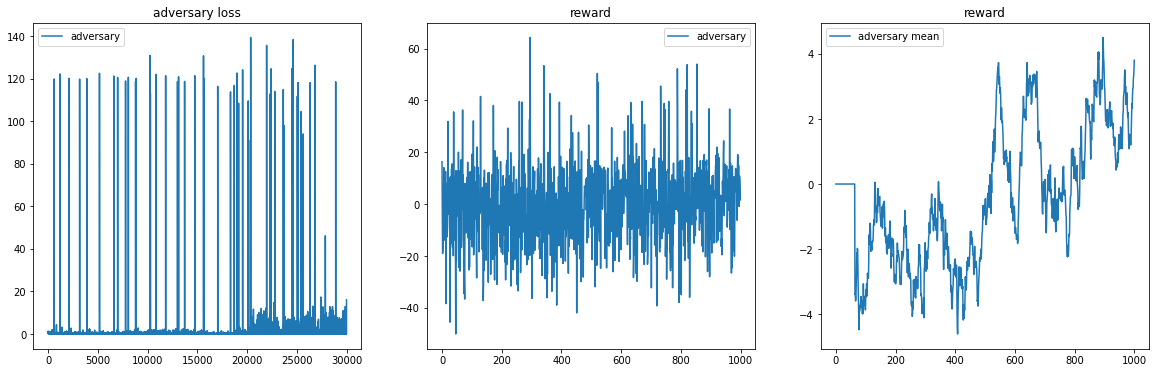

In [25]:
# train model
adversary_net, logger = train(config)

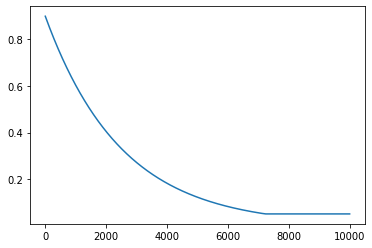

In [57]:
eps_start = 0.9
eps_end = 0.05
eps_decay = 0.9996
epsilon = eps_start

eps = [epsilon]
for i in range(10_000):
    epsilon = max((epsilon*eps_decay), eps_end)
    eps.append(epsilon)

plt.plot(eps)

In [10]:
# load adversary net
adversary_net = SimpleTagNet(config, "adversary").to(config.device)
adversary_net.load_state_dict(torch.load('./models/batched-baseline-rnn/adversary-net-19968.pth'))

<All keys matched successfully>

In [68]:
# save logs
with open("models/batched-baseline-rnn/log.json", "w") as f:
    json.dump(logger, f)

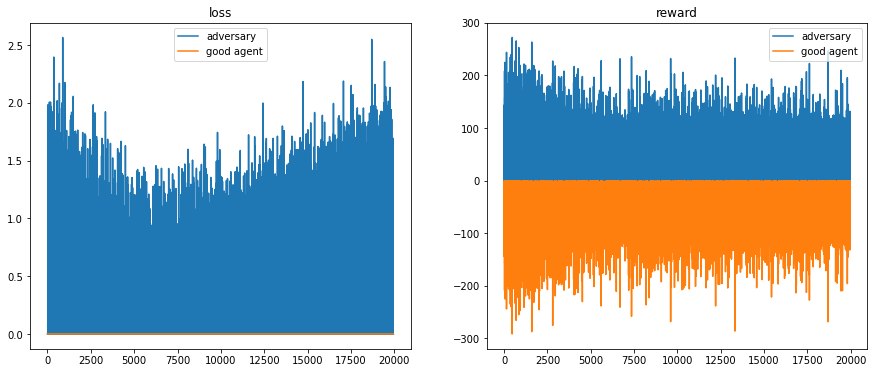

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.ravel()

axes[0].plot(logger.episodic_losses.adversary[50:], label="adversary")
axes[0].plot(logger.episodic_losses.agent[50:], label="good agent")
axes[0].set_title("loss")
axes[0].legend()

axes[1].plot(logger.episodic_rewards.adversary[50:], label="adversary")
axes[1].plot(logger.episodic_rewards.agent[50:], label="good agent")
axes[1].set_title("reward")
axes[1].legend()

In [ ]:
fig.savefig("models/batched-baseline-rnn/vis.png")

In [4]:
# load logs
with open("models/batched-baseline-rnn/log.json", "r") as f:
    logger = json.load(f)

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def f(a, n):
    """Zero out beginning of last axis"""
    pad_width = [(0, 0) for _ in range(a.ndim - 1)] + [(n, 0)]
    return np.pad(a, pad_width, mode='constant', constant_values=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.ravel()

axes[0].plot(logger["episodic_losses"]["adversary"][50:], label="adversary")
axes[0].plot(logger["episodic_losses"]["agent"][50:], label="good agent")
axes[0].set_title("loss")
axes[0].legend()

adversary_episodic_rewards = np.array(logger["episodic_rewards"]["adversary"])*10
mean_adversary_episodic_rewards = f(moving_average(adversary_episodic_rewards, n=512), 0)
# axes[1].plot(adversary_episodic_rewards, label="adversary")
axes[1].plot(mean_adversary_episodic_rewards, label="adversary mean")
# axes[1].plot(logger["episodic_rewards"]["agent"][50:], label="good agent")
axes[1].set_title("reward")
axes[1].legend()

In [20]:
def visualize(config, adversary_net):
    adversary_net.eval()
    with torch.no_grad():
        return run_episode(config, adversary_net, should_render=True, is_val=True)

episode = visualize(config, adversary_net)
print("episode steps", episode.steps)
print("episode rewards", *episode.reward.items())

episode steps 31
episode rewards ('adversary', 34.37761549440293) ('agent', -34.37761549440293)
